In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install biopython
!pip install goatools

In [18]:
import os
import pandas as pd
import math
import numpy as np
from scipy.stats import norm, fisher_exact
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from collections import Counter
from time import sleep
import networkx as nx
from Bio import SeqIO
from Bio.ExPASy import Prosite
import re
import string
import gzip
import urllib.request
from wordcloud import WordCloud
from goatools.obo_parser import GODag

# Models Building

1. Retrieve homologous proteins starting from the given input sequence performing an NCBI BLAST search (https://www.ebi.ac.uk/jdispatcher/sss/ncbiblast) against UniProtKB/Swiss-Prot (The manually annotated section of UniProtKB).
Parameters:
- Sequence type: Protein
- Program: blastp
- Matrix (The substitution matrix used for scoring alignments when searching the database): BLOSUM62
- Gap open (Penalty taken away from the score when a gap is created in sequence. Increasing the gap opening penalty will decrease the number of gaps in the final alignment): 11
- Gap extend (Penalty taken away from the score for each base or residue in the gap. Increasing the gap extension penalty favors short gaps in the final alignment, conversly decreasing the gap extension penalty favors long gaps in the final alignment): 1
- Exp. thr (Limits the number of scores and alignments reported based on the expectation value. This is the maximum number of times the match is expected to occur by chance): 1e-5
- Scores (Maximum number of match score summaries reported in the result output): 1000
- Alignments (Maximum number of match alignments reported in the result output): 1000
- Sequence range (Specify a range or section of the input sequence to use in the search): Start-End
- HSPS (Maximum number of HSPs alignments to keep for any single query-subject pair): 100
- Word size (Word size for wordfinder algorithm): 6

Obtained 302 results (sequences) with E-value ranging from 2.5e-69 to 9.4e-6 Downloaded all the alignments in FASTA format. The resulting file is located in the 'data/blast' folder and is named blast_swissprot.fasta.

2. Generate a multiple sequence alignment (MSA) starting from retrieved hits using ClustalOmega and MUSCLE.

ClustalOmega (maximum 4000 sequences):
- Sequence type: Protein
- Output format: Pearson/FASTA
- Other default parameters

MUSCLE (maximum 500 sequences):
- Output format: Pearson/FASTA
- Other default parameters

Result Files -> Alignment in FASTA format (.aln-fasta) and The alignment in FASTA format converted by Seqret (.fa). The output files are inside 'data/msa' folder and are named: 'clustalo.fa' and 'muscle.fa'

3. Edit the MSA with JalView to remove not conserved positions (columns) and/or redundant information (rows)
- No refinement (Clustal Omega and MUSCLE - 302 sequences)
- Remove redundancy at 100% threshold and remove empty columns (Clustal Omega - 178 sequences, MUSCLE-277 sequences)
- Remove redundancy at 100% threshold, remove empty columns and remove poorly occupied columns (less than 15 percent) (Clustal Omega - 178 sequences, MUSCLE-277 sequences)
- Remove redundancy at 100% threshold, remove empty columns and remove columns with consensus below 10% (Clustal Omega - 178 sequences, MUSCLE-277 sequences)

The output files are inside 'data/msa_after_jalview' folder and are named: 'clustalo-1.fa', 'clustalo-2.fa', 'clustalo-3.fa', 'clustalo-4.fa',
'muscle-1.fa', 'muscle-2.fa', 'muscle-3.fa', 'muscle-4.fa'.

4. Build an HMM model starting from the MSA

The output files are inside the 'data/hmm' folder and are named: 'clustalo-1.hmm', 'clustalo-2.hmm', 'clustalo-3.hmm', 'clustalo-4.hmm',
'muscle-1.hmm', 'muscle-2.hmm', 'muscle-3.hmm', 'muscle-4.hmm'.

5. Build a PSSM model starting from the MSA

The output files are inside the 'data/pssm' folder and are named: 'clustalo-1.pssm', 'clustalo-2.pssm', 'clustalo-3.pssm', 'clustalo-4.pssm', 'muscle-1.pssm', 'muscle-2.pssm', 'muscle-3.pssm', 'muscle-4.pssm'.


To build HMM from a MSA file it is necessary to use the command line version of HMMER.

Install HMMER (latest version):
```
wget http://eddylab.org/software/hmmer/hmmer.tar.gz
tar -xzf hmmer.tar.gz
cd hmmer-3.3.4
./configure
make
```

Generate an HMM model from a Fasta MSA:
```
hmmer-3.3.4/src/hmmbuild data/hmm/clustalo-1.hmm data/msa_after_jalview/clustalo-1.fa
```

To build PSSM from a MSA file it is necessary to use the command line version of BLAST.

Install NCBI BLAST+ (latest version):
```
wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.16.0+-x64-linux.tar.gz
tar -xzf ncbi-blast-2.16.0+-x64-linux.tar.gz
```
Create a PSSM from a Fasta MSA:
```
ncbi-blast-2.16.0+/bin/psiblast -subject data/msa_after_jalview/clustalo-1.fa -in_msa data/msa_after_jalview/clustalo-1.fa -out_pssm data/pssm/clustalo-1.pssm -out_ascii_pssm data/pssm/clustalo-1.pssm_ascii
```
The content of the file in the -subject option is irrelevant, just use a valid fasta file.



In [19]:
# Constants
SWISSPROT_SIZE = 572619 # Total number of SwissProt proteins
SWISSPROT_LENGTH = 207431389 # Total residue count in SwissProt
MSA_METHODS = ["clustalo", "muscle"] # Alignment methods used
DATA_FOLDER ="/content/drive/MyDrive/Biological-Data-Project/data/" # Base data folder

# Models Evaluation

## Prediction

In this part we generate the prediction by running HMM-SEARCH and PSI-BLAST against the SwissProt database, with our eight different models described previously. We collected the list of retrieved hits and the matching positions of our models in the retrieved hits. The output files ase inside the 'data/predictions' folder and are names: 'clustalo-1-hmmsearch.tsv', 'clustalo-2-hmmsearch.tsv', 'clustalo-3-hmmsearch.tsv', 'clustalo-4-hmmsearch.tsv', 'muscle-1-hmmsearch.tsv', 'muscle-2-hmmsearch.tsv', 'muscle-3-hmmsearch.tsv', 'muscle-4-hmmsearch.tsv',
'clustalo-1-pssmsearch.csv', 'clustalo-2-pssmsearch.csv', 'clustalo-3-pssmsearch.csv', 'clustalo-4-pssmsearch.csv', 'muscle-1-pssmsearch.csv', 'muscle-2-pssmsearch.csv', 'muscle-3-pssmsearch.csv', 'muscle-4-pssmsearch.csv',

## Ground Truth

Next step is to define a ground truth to evaluate our results and this is done by finding all proteins in SwissProt annotated with the Pfam domain - PF00085, given in the file named 'protein-matching-PF00085/tsv'. To do this, we collect the set of SwissProt proteins matching the assigned Pfam domain, and also collect the matching positions of the Pfam domain in the sequences by performing a search for the domain by its id on the InterPro database. We found 474 proteins from SwissProt that contain the Thioredoxin domain.

In [20]:
# Read Ground Truth Data
def load_ground_truth(file_path):
    """Loads ground truth data from TSV file and processes matching residue positions."""

    # Read the TSV file into a pandas DataFrame
    df = pd.read_csv(file_path, sep='\t')
    unique_proteins = df.shape[0]
    print(f"Number of unique proteins with PF00085 domain: {unique_proteins}")

    # Splitting the "Matches" column by comma to create multiple rows
    df = df.assign(Matches=df["Matches"].str.split(",")).explode("Matches")

    # Splitting the "Matches" column by ".." into "Start" and "End"
    df[["Start", "End"]] = df["Matches"].str.split("\.\.", expand=True)

    # Dropping the old "Matches column"
    df.drop(columns=["Matches"], inplace=True)

    # Convert "Start" and "End" to integers
    df["Start"] = df["Start"].astype(int)
    df["End"] = df["End"].astype(int)

    return df

In [21]:
gt_df = load_ground_truth(f"{DATA_FOLDER}protein-matching-PF00085.tsv")
gt_df

Number of unique proteins with PF00085 domain: 474


,Accession,Source Database,Name,Tax ID,Tax Name,Length,Entry Accession,Start,End
0,A0A1L1SUL6,reviewed,Thioredoxin domain-containing protein 6,10090,Mus musculus,329,PF00085,14,109
1,A0A509AQW5,reviewed,Thioredoxin 2,5823,Plasmodium berghei (strain Anka),157,PF00085,59,154
2,A0A8M1N5Y4,reviewed,Protein disulfide-isomerase tmx3a,7955,Danio rerio,437,PF00085,32,121
3,A2YIW7,reviewed,Thioredoxin H-type,39946,Oryza sativa subsp. indica,122,PF00085,9,109
4,A2YUQ6,reviewed,"Thioredoxin-like protein CITRX, chloroplastic",39946,Oryza sativa subsp. indica,189,PF00085,83,182
...,...,...,...,...,...,...,...,...,...
469,Q9ZP20,reviewed,"Thioredoxin M5, chloroplastic",39947,Oryza sativa subsp. japonica,172,PF00085,67,167
470,Q9ZP21,reviewed,"Thioredoxin M-type, chloroplastic",4565,Triticum aestivum,175,PF00085,70,170
471,Q9ZPE9,reviewed,5'-adenylylsulfate reductase-like 6,3702,Arabidopsis thaliana,295,PF00085,79,156
472,Q9ZPH2,reviewed,Monothiol glutaredoxin-S17,3702,Arabidopsis thaliana,488,PF00085,16,102


## Evaluation

The evaluation of the models is done with two different methods:

1. A comparison at protein level, measuring the ability of our models to retrieve the same proteins matched by Pfam.
2. A comparison at residue level, measuring the ability of our models to match the same positions matched by Pfam.

The metrics used are precision, recall, F-score, balanced accuracy, MCC.

In [22]:
def calculate_metrics(tp, tn, fp, fn):
    """
    Computes various classification metrics.

    Parameters:
        tp (int): True Positives
        tn (int): True Negatives
        fp (int): False Positives
        fn (int): False Negatives

    Returns:
        dict: Dictionary containing precision, recall, F-score, balanced accuracy, and MCC.
    """
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = 2 * (precision * recall) / (precision + recall)
    balanced_accuracy = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp)))
    mcc = ((tp * tn) - (fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    data = [[precision, recall, fscore, balanced_accuracy, mcc]]
    data_df = pd.DataFrame(data, columns = ["Precision", "Recall", "F-score", "Balanced Accuracy", "MCC"])
    display(data_df)
    return {
        "Precision": precision,
        "Recall": recall,
        "F-score": fscore,
        "Balanced accuracy": balanced_accuracy,
        "MCC": mcc
    }

In [24]:
def read_hmm_tsv(file_path):
    df = pd.read_csv(file_path, sep="\t", na_values=["-", "NA"])
    return df

def read_pssm_csv(file_path):
    df = pd.read_csv(file_path, sep=",", names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
    df[['acc', 'version']] = df['subject'].str.split(pat='.', n=1, expand=True)
    return df

In [25]:
def compare_at_protein_level(search_results, ground_truth, sr_accession_column, gt_accession_column):
    """
    Compares HMM or PSSM search results with ground truth at the protein level.

    Parameters:
        search_results (pd.DataFrame): HMM or PSSM search results DataFrame.
        ground_truth (pd.DataFrame): Ground truth DataFrame.
        sr_accession_column (str): Column name for the search result accessions.
        gt_accession_column (str): Column name for the ground truth accessions.

    Returns:
        dict: Metrics dictionary.
    """
    # Convert protein lists to sets using the correct column names
    sr_proteins = set(search_results[sr_accession_column])
    gt_proteins = set(ground_truth[gt_accession_column])

    # Compute metrics
    # True Positives: proteins found in both sets
    tp = len(sr_proteins.intersection(gt_proteins))
    # False Positives: found in HMMSEARCH or PSI-BLAST, but not in ground truth
    fp = len(sr_proteins - gt_proteins)
    # False Negatives: found in ground truth, but not retrieved by HMMSEARCH or PSI-BLAST
    fn = len(gt_proteins - sr_proteins)
    # True Negatives: SWISSPROT_SIZE - TP
    tn = SWISSPROT_SIZE - tp

    data = [[tp, fp, fn, tn]]
    data_df = pd.DataFrame(data, columns=['TP', 'FP', 'FN', 'TN'])
    display(data_df)
    return calculate_metrics(tp, tn, fp, fn)

In [26]:
# Run evaluation at protein level for HMM models
for msa in MSA_METHODS:
    for i in range(1, 5):
        hmm_file = os.path.join(DATA_FOLDER, f"predictions/{msa}-{i}-hmmsearch.tsv")
        hmmsearch_df = read_hmm_tsv(hmm_file)
        results = compare_at_protein_level(hmmsearch_df, gt_df, "Target Accession", "Accession")
        print(f"Results for {msa}-{i}-hmmsearch.tsv:")
        print(results)

,TP,FP,FN,TN
0,439,97,35,572180


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.81903,0.92616,0.869307,0.962995,0.870837


Results for clustalo-1-hmmsearch.tsv:
{'Precision': 0.8190298507462687, 'Recall': 0.9261603375527426, 'F-score': 0.8693069306930693, 'Balanced accuracy': 0.9629954196076995, 'MCC': 0.8708372407318762}


,TP,FP,FN,TN
0,436,103,38,572183


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.808905,0.919831,0.860809,0.959826,0.862467


Results for clustalo-2-hmmsearch.tsv:
{'Precision': 0.8089053803339518, 'Recall': 0.919831223628692, 'F-score': 0.8608094768015794, 'Balanced accuracy': 0.959825621844296, 'MCC': 0.8624672555723863}


,TP,FP,FN,TN
0,443,104,31,572176


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.809872,0.934599,0.867777,0.967209,0.86989


Results for clustalo-3-hmmsearch.tsv:
{'Precision': 0.8098720292504571, 'Recall': 0.9345991561181435, 'F-score': 0.8677766895200785, 'Balanced accuracy': 0.9672087134473433, 'MCC': 0.8698895990309423}


,TP,FP,FN,TN
0,444,103,30,572175


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.8117,0.936709,0.869736,0.968264,0.871855


Results for clustalo-4-hmmsearch.tsv:
{'Precision': 0.8117001828153565, 'Recall': 0.9367088607594937, 'F-score': 0.8697355533790402, 'Balanced accuracy': 0.9682644391517072, 'MCC': 0.8718552406682449}


,TP,FP,FN,TN
0,430,90,44,572189


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.826923,0.907173,0.865191,0.953508,0.866004


Results for muscle-1-hmmsearch.tsv:
{'Precision': 0.8269230769230769, 'Recall': 0.9071729957805907, 'F-score': 0.8651911468812877, 'Balanced accuracy': 0.9535078649158196, 'MCC': 0.8660037506259183}


,TP,FP,FN,TN
0,430,89,44,572189


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.828516,0.907173,0.866062,0.953509,0.866839


Results for muscle-2-hmmsearch.tsv:
{'Precision': 0.8285163776493256, 'Recall': 0.9071729957805907, 'F-score': 0.866062437059416, 'Balanced accuracy': 0.9535087384796592, 'MCC': 0.8668385618491912}


,TP,FP,FN,TN
0,440,84,34,572179


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.839695,0.92827,0.881764,0.964062,0.882771


Results for muscle-3-hmmsearch.tsv:
{'Precision': 0.8396946564885496, 'Recall': 0.9282700421940928, 'F-score': 0.8817635270541081, 'Balanced accuracy': 0.9640616282689236, 'MCC': 0.8827711999423898}


,TP,FP,FN,TN
0,446,84,28,572173


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.841509,0.940928,0.888446,0.970391,0.889736


Results for muscle-4-hmmsearch.tsv:
{'Precision': 0.8415094339622642, 'Recall': 0.9409282700421941, 'F-score': 0.8884462151394422, 'Balanced accuracy': 0.9703907414234653, 'MCC': 0.8897361727216047}


In [27]:
# Run evaluation at protein level for PSSM models
for msa in MSA_METHODS:
    for i in range(1, 5):
        pssm_file = os.path.join(DATA_FOLDER, f"predictions/{msa}-{i}-pssmsearch.csv")
        pssmsearch_df = read_pssm_csv(pssm_file)
        results = compare_at_protein_level(pssmsearch_df, gt_df, "acc", "Accession")
        print(f"Results for {msa}-{i}-pssmsearch.csv:")
        print(results)

,TP,FP,FN,TN
0,431,69,43,572188


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.862,0.909283,0.88501,0.954581,0.885228


Results for clustalo-1-pssmsearch.csv:
{'Precision': 0.862, 'Recall': 0.9092827004219409, 'F-score': 0.8850102669404517, 'Balanced accuracy': 0.9545810626129158, 'MCC': 0.8852284639747053}


,TP,FP,FN,TN
0,402,98,72,572217


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.804,0.848101,0.825462,0.923965,0.825608


Results for clustalo-2-pssmsearch.csv:
{'Precision': 0.804, 'Recall': 0.8481012658227848, 'F-score': 0.8254620123203286, 'Balanced accuracy': 0.9239650157250527, 'MCC': 0.8256083010321255}


,TP,FP,FN,TN
0,428,72,46,572191


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.856,0.902954,0.87885,0.951414,0.879061


Results for clustalo-3-pssmsearch.csv:
{'Precision': 0.856, 'Recall': 0.9029535864978903, 'F-score': 0.8788501026694044, 'Balanced accuracy': 0.9514138851105542, 'MCC': 0.8790608604352664}


,TP,FP,FN,TN
0,428,72,46,572191


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.856,0.902954,0.87885,0.951414,0.879061


Results for clustalo-4-pssmsearch.csv:
{'Precision': 0.856, 'Recall': 0.9029535864978903, 'F-score': 0.8788501026694044, 'Balanced accuracy': 0.9514138851105542, 'MCC': 0.8790608604352664}


,TP,FP,FN,TN
0,427,73,47,572192


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.854,0.900844,0.876797,0.950358,0.877005


Results for muscle-1-pssmsearch.csv:
{'Precision': 0.854, 'Recall': 0.9008438818565401, 'F-score': 0.8767967145790555, 'Balanced accuracy': 0.950358159288645, 'MCC': 0.8770049926132203}


,TP,FP,FN,TN
0,427,73,47,572192


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.854,0.900844,0.876797,0.950358,0.877005


Results for muscle-2-pssmsearch.csv:
{'Precision': 0.854, 'Recall': 0.9008438818565401, 'F-score': 0.8767967145790555, 'Balanced accuracy': 0.950358159288645, 'MCC': 0.8770049926132203}


,TP,FP,FN,TN
0,427,73,47,572192


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.854,0.900844,0.876797,0.950358,0.877005


Results for muscle-3-pssmsearch.csv:
{'Precision': 0.854, 'Recall': 0.9008438818565401, 'F-score': 0.8767967145790555, 'Balanced accuracy': 0.950358159288645, 'MCC': 0.8770049926132203}


,TP,FP,FN,TN
0,431,69,43,572188


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.862,0.909283,0.88501,0.954581,0.885228


Results for muscle-4-pssmsearch.csv:
{'Precision': 0.862, 'Recall': 0.9092827004219409, 'F-score': 0.8850102669404517, 'Balanced accuracy': 0.9545810626129158, 'MCC': 0.8852284639747053}


In [28]:
# Convert to dictionary mapping each protein to a list of residue ranges
def get_residue_ranges(df, protein_col, start_col, end_col):
    """Maps proteins to residue positions from a DataFrame."""
    protein_residues = {}
    for _, row in df.iterrows():
        protein = row[protein_col]
        start, end = row[start_col], row[end_col]
        if protein not in protein_residues:
            protein_residues[protein] = set()
        # Store all residue positions
        protein_residues[protein].update(range(start, end+1))
    return protein_residues

In [29]:
# Extract residue mappings from both dataframes
def compare_at_residue_level(search_results, ground_truth, search_type="HMM"):
    """
    Compares HMM or PSSM search results with ground truth at the residue level.

    Parameters:
        hmmsearch (pd.DataFrame): HMM or PSSM search results DataFrame.
        ground_truth (pd.DataFrame): Ground truth DataFrame.
        search_type (str): Type of search ("HMM" or "PSSM").

    Returns:
        dict: Metrics dictionary.
    """

    # Column mapping based on search type
    column_mapping = {
        "HMM": ("Target Accession", "Target Ali. Start", "Target Ali. End"),
        "PSSM": ("acc", "s_start", "s_end")
    }

    if search_type not in column_mapping:
        raise ValueError("Invalid search type. Use 'HMM' or 'PSSM'.")

    acc_col, start_col, end_col = column_mapping[search_type]

    sr_residues = get_residue_ranges(search_results, acc_col, start_col, end_col)
    gt_residues = get_residue_ranges(ground_truth, "Accession", "Start", "End")

    # Initialize TP, TN, FP, FN
    tp, tn, fp, fn = 0, 0, 0, 0

    # Calculate metrics for proteins in both dataframes
    all_proteins = set(sr_residues.keys()).union(set(gt_residues.keys()))

    for protein in all_proteins:
        predicted_residues = sr_residues.get(protein, set())
        actual_residues = gt_residues.get(protein, set())

        tp += len(predicted_residues.intersection(actual_residues))
        fp += len(predicted_residues - actual_residues)
        fn += len(actual_residues - predicted_residues)

    tn = SWISSPROT_LENGTH - tp - fp - fn

    data = [[tp, fp, fn, tn]]
    data_df = pd.DataFrame(data, columns=['TP', 'FP', 'FN', 'TN'])
    display(data_df)
    return calculate_metrics(tp, tn, fp, fn)

In [30]:
# Run evaluation at residue level for HMM models
for msa in MSA_METHODS:
    for i in range(1, 5):
        hmm_file = f"{DATA_FOLDER}predictions/{msa}-{i}-hmmsearch.tsv"
        hmmsearch_df = read_hmm_tsv(hmm_file)
        results = compare_at_residue_level(hmmsearch_df, gt_df, "HMM")
        print(f"Results for {msa}-{i}-hmmsearch.tsv:")
        print(results)

,TP,FP,FN,TN
0,52288,56753,3866,207318482


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.479526,0.931154,0.633046,0.96544,0.668105


Results for clustalo-1-hmmsearch.tsv:
{'Precision': 0.47952604983446595, 'Recall': 0.9311536132777718, 'F-score': 0.6330457943642362, 'Balanced accuracy': 0.9654399701453673, 'MCC': 0.6681046491750511}


,TP,FP,FN,TN
0,51739,56663,4415,207318572


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.477288,0.921377,0.628832,0.960552,0.663033


Results for clustalo-2-hmmsearch.tsv:
{'Precision': 0.4772882419143558, 'Recall': 0.9213769277344446, 'F-score': 0.6288315223996694, 'Balanced accuracy': 0.9605518443716494, 'MCC': 0.6630326877800667}


,TP,FP,FN,TN
0,52396,45288,3758,207329947


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.536383,0.933077,0.681184,0.966429,0.707356


Results for clustalo-3-hmmsearch.tsv:
{'Precision': 0.5363826215142705, 'Recall': 0.9330768956797378, 'F-score': 0.6811841027574461, 'Balanced accuracy': 0.966429254473554, 'MCC': 0.707355769133069}


,TP,FP,FN,TN
0,52273,31972,3881,207343263


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.620488,0.930886,0.744635,0.965366,0.759928


Results for clustalo-4-hmmsearch.tsv:
{'Precision': 0.620487862781174, 'Recall': 0.9308864907219432, 'F-score': 0.7446349332972457, 'Balanced accuracy': 0.9653661580462785, 'MCC': 0.7599280786640568}


,TP,FP,FN,TN
0,51332,56574,4822,207318661


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.47571,0.914129,0.625771,0.956928,0.659325


Results for muscle-1-hmmsearch.tsv:
{'Precision': 0.4757103404815302, 'Recall': 0.9141290023862948, 'F-score': 0.6257710593685236, 'Balanced accuracy': 0.956928096284432, 'MCC': 0.6593250986731093}


,TP,FP,FN,TN
0,51329,56656,4825,207318579


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.475335,0.914076,0.625433,0.956901,0.659045


Results for muscle-2-hmmsearch.tsv:
{'Precision': 0.47533453720424135, 'Recall': 0.9140755778751292, 'F-score': 0.6254333217577785, 'Balanced accuracy': 0.9569011863196097, 'MCC': 0.65904518899513}


,TP,FP,FN,TN
0,52130,46256,4024,207328979


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.529852,0.92834,0.674647,0.964058,0.701246


Results for muscle-3-hmmsearch.tsv:
{'Precision': 0.5298518081840913, 'Recall': 0.9283399223563771, 'F-score': 0.6746473404943705, 'Balanced accuracy': 0.9640584338784124, 'MCC': 0.7012463100309321}


,TP,FP,FN,TN
0,52621,14907,3533,207360328


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.779247,0.937084,0.850908,0.968506,0.854487


Results for muscle-4-hmmsearch.tsv:
{'Precision': 0.7792471271176401, 'Recall': 0.937083734017167, 'F-score': 0.8509079736744232, 'Balanced accuracy': 0.968505924915498, 'MCC': 0.8544868796792036}


In [32]:
# Run evaluation at residue level for PSSM models
for msa in MSA_METHODS:
    for i in range(1, 5):
        pssm_file = f"{DATA_FOLDER}predictions/{msa}-{i}-pssmsearch.csv"
        pssmsearch_df = read_pssm_csv(pssm_file)
        results = compare_at_residue_level(pssmsearch_df, gt_df, "PSSM")
        print(f"Results for {msa}-{i}-pssmsearch.tsv:")
        print(results)

,TP,FP,FN,TN
0,51509,12482,4645,207362753


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.804941,0.917281,0.857447,0.95861,0.859237


Results for clustalo-1-pssmsearch.tsv:
{'Precision': 0.8049413198731071, 'Recall': 0.9172810485450725, 'F-score': 0.8574472512380874, 'Balanced accuracy': 0.9586104290685453, 'MCC': 0.8592371166029937}


,TP,FP,FN,TN
0,49124,42963,7030,207332272


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.533452,0.874809,0.662759,0.937301,0.683029


Results for clustalo-2-pssmsearch.tsv:
{'Precision': 0.5334520616373647, 'Recall': 0.8748085621683228, 'F-score': 0.6627586160373986, 'Balanced accuracy': 0.9373006934981124, 'MCC': 0.6830287394868689}


,TP,FP,FN,TN
0,51326,22517,4828,207352718


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.695069,0.914022,0.789649,0.956957,0.797002


Results for clustalo-3-pssmsearch.tsv:
{'Precision': 0.6950692685833457, 'Recall': 0.9140221533639634, 'F-score': 0.7896489918998131, 'Balanced accuracy': 0.9569567862070366, 'MCC': 0.797001856497905}


,TP,FP,FN,TN
0,51311,17500,4843,207357735


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.74568,0.913755,0.821206,0.956835,0.8254


Results for clustalo-4-pssmsearch.tsv:
{'Precision': 0.7456801964802139, 'Recall': 0.9137550308081348, 'F-score': 0.8212059376625455, 'Balanced accuracy': 0.9568353213590552, 'MCC': 0.8253997609615201}


,TP,FP,FN,TN
0,51031,51334,5123,207323901


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.49852,0.908769,0.643847,0.954261,0.672974


Results for muscle-1-pssmsearch.tsv:
{'Precision': 0.4985200019537928, 'Recall': 0.908768743099334, 'F-score': 0.6438471098101805, 'Balanced accuracy': 0.9542606007435724, 'MCC': 0.6729736562604435}


,TP,FP,FN,TN
0,51031,51334,5123,207323901


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.49852,0.908769,0.643847,0.954261,0.672974


Results for muscle-2-pssmsearch.tsv:
{'Precision': 0.4985200019537928, 'Recall': 0.908768743099334, 'F-score': 0.6438471098101805, 'Balanced accuracy': 0.9542606007435724, 'MCC': 0.6729736562604435}


,TP,FP,FN,TN
0,51278,57567,4876,207317668


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.47111,0.913167,0.621555,0.956445,0.655782


Results for muscle-3-pssmsearch.tsv:
{'Precision': 0.47111029445541824, 'Recall': 0.9131673611853118, 'F-score': 0.6215552821532252, 'Balanced accuracy': 0.9564448814732722, 'MCC': 0.6557822007770752}


,TP,FP,FN,TN
0,51336,32183,4818,207343052


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.614663,0.9142,0.735088,0.957023,0.749539


Results for muscle-4-pssmsearch.tsv:
{'Precision': 0.6146625318789737, 'Recall': 0.9142002350678491, 'F-score': 0.7350883850135674, 'Balanced accuracy': 0.9570225214796031, 'MCC': 0.7495385255742685}


# Taxonomy

In this part we collect the taxonomic lineage from UniProt for each protein in the defined protein family by our best model. Then, we plot the taxonomic tree of the family with node sizes proportional to their relative abundance.



In [33]:
# Function to fetch XML data from UniProt
def fetch_uniprot_xml(accession):
    """
    Fetches XML data for a given protein accession from UniProt.

    Parameters:
        accession (str): Protein accession ID.

    Returns:
        str: XML response or None on failure.
    """
    url = f"https://www.uniprot.org/uniprot/{accession}.xml"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch {accession}: {response.status_code}")
        return None

# Function to parse XML and extract taxonomy details
def parse_uniprot_xml(xml_data):
    """
    Extracts taxonomy lineage from UniProt XML response.

    Parameters:
        xml_data (str): XML response from UniProt.

    Returns:
        str: Taxonomic lineage path.
    """
    root = ET.fromstring(xml_data)
    lineage = [node.text for node in root.findall(".//{http://uniprot.org/uniprot}lineage/{http://uniprot.org/uniprot}taxon")]
    return " > ".join(lineage) if lineage else "N/A"

In [34]:
best_model = read_hmm_tsv(f"{DATA_FOLDER}predictions/muscle-4-hmmsearch.tsv")
protein_ids = best_model["Target Accession"].unique().tolist()

In [35]:
# Collect taxonomy lineage data
def compute_relative_abundance(protein_ids):
    """Convert lineage data to a DataFrame and compute relative abundance."""
    lineage_counter = Counter()
    for protein_id in protein_ids:
        xml_data = fetch_uniprot_xml(protein_id)
        if xml_data:
            lineage_path = parse_uniprot_xml(xml_data)
            if lineage_path != "N/A":
                lineage_counter[lineage_path] += 1
        sleep(1)  # Prevents server overload
    df = pd.DataFrame(lineage_counter.items(), columns=["Lineage", "Count"])
    total_count = df["Count"].sum()
    df["Relative_Abundance"] = df["Count"] / total_count
    return df

In [36]:
relative_abundance_df = compute_relative_abundance(protein_ids)
relative_abundance_df

,Lineage,Count,Relative_Abundance
0,Eukaryota > Metazoa > Chordata > Craniata > Ve...,10,0.018868
1,Eukaryota > Metazoa > Chordata > Craniata > Ve...,30,0.056604
2,Eukaryota > Metazoa > Chordata > Craniata > Ve...,30,0.056604
3,Eukaryota > Metazoa > Chordata > Craniata > Ve...,20,0.037736
4,Eukaryota > Metazoa > Chordata > Craniata > Ve...,6,0.011321
...,...,...,...
139,Bacteria > Pseudomonadota > Alphaproteobacteri...,1,0.001887
140,Eukaryota > Metazoa > Chordata > Tunicata > As...,1,0.001887
141,Eukaryota > Metazoa > Echinodermata > Eleuther...,1,0.001887
142,Eukaryota > Metazoa > Chordata > Craniata > Ve...,1,0.001887


In [37]:
# Set threshold for visibility
ABUNDANCE_THRESHOLD = 0.05

def plot_taxonomic_tree(relative_abundance_df, abundance_threshold=ABUNDANCE_THRESHOLD):
    """Build and plot the taxonomic tree from the DataFrame with the relative abundances."""
    G = nx.DiGraph()
    node_sizes = {}

    # Filter rows based on abundance threshold
    filtered_df = relative_abundance_df[relative_abundance_df["Relative_Abundance"] >= abundance_threshold]

    for _, row in filtered_df.iterrows():
        lineage = row["Lineage"]
        abundance = row["Relative_Abundance"]

        taxa = lineage.split(" > ")
        for i in range(len(taxa) - 1):
            parent, child = taxa[i], taxa[i + 1]
            G.add_edge(parent, child)
            node_sizes[child] = abundance * 2000  # Scale for visibility

    # Plot the tree
    plt.figure(figsize=(12, 8))
    pos = nx.kamada_kawai_layout(G)  # Layout for hierarchy
    nx.draw(G, pos, with_labels=True, node_size=[node_sizes.get(node, 300) for node in G.nodes()],
            font_size=8, edge_color="gray")
    plt.title("Taxonomic Tree of Protein Family")
    plt.show()

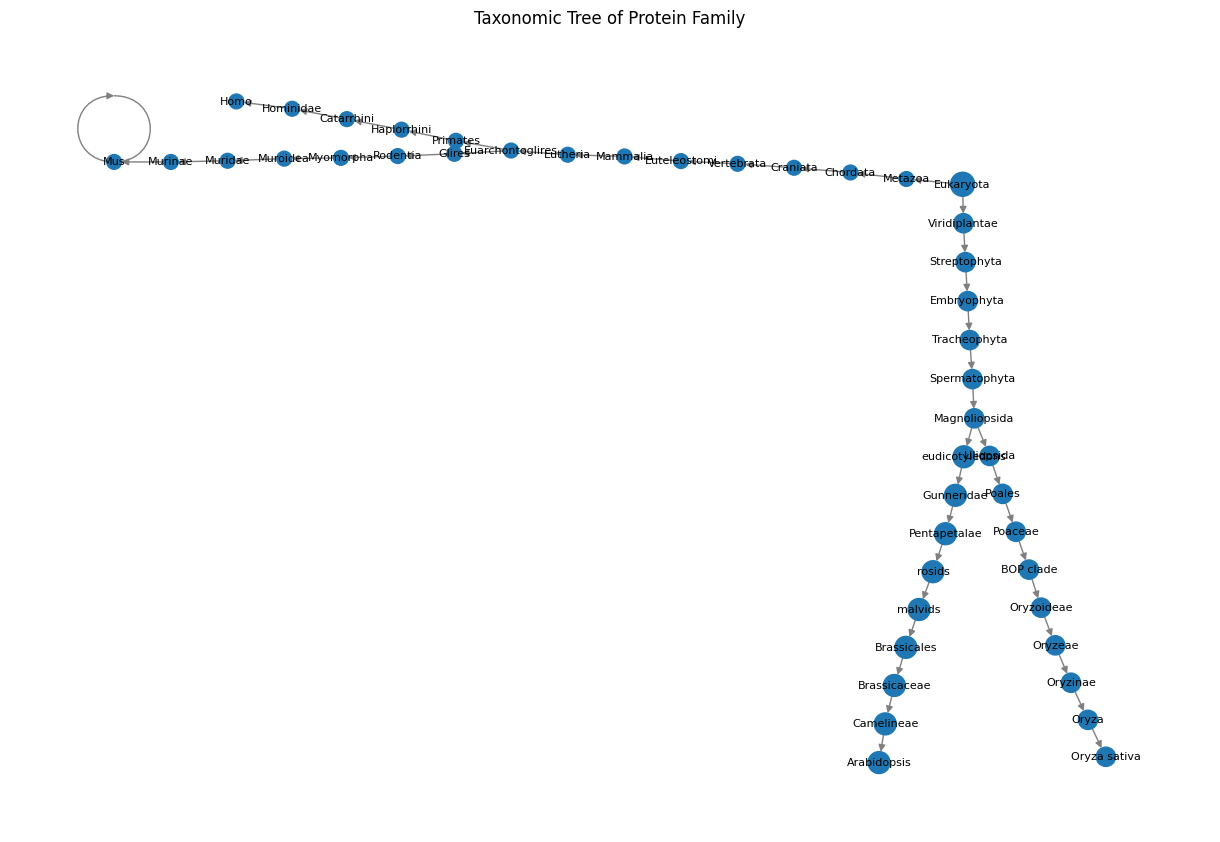

In [38]:
plot_taxonomic_tree(relative_abundance_df)

# Function

In [39]:
go_obo_url = "http://purl.obolibrary.org/obo/go.obo"
output_file = "go.obo"

urllib.request.urlretrieve(go_obo_url, output_file)
print("GO ontology file downloaded successfully!")

GO ontology file downloaded successfully!


In [40]:
# Paths to files
uniprot_xml_file = f"{DATA_FOLDER}uniprot_sprot.xml.gz"
go_obo_file = f"{DATA_FOLDER}go.obo"

# Function to parse UniProt XML iteratively and extract GO annotations
def parse_uniprot_go_iterative(uniprot_xml_file, target_accessions):
    """Efficiently parse UniProt XML using iterparse() to handle large files."""
    swissprot_go_annotations = {}
    family_sequences_go_annotations = {}

    # Open the gzip file in text mode
    with gzip.open(uniprot_xml_file, 'rt') as handle:
        context = ET.iterparse(handle, events=('start', 'end'))
        _, root = next(context)  # Get root element

        namespace = {'ns': 'https://uniprot.org/uniprot'}

        for event, elem in context:
            if event == 'end' and elem.tag.endswith('entry'):
                protein_id_elem = elem.find('ns:accession', namespace)
                if protein_id_elem is not None:
                    protein_id = protein_id_elem.text

                    go_terms = [
                        ref.attrib['id']
                        for ref in elem.findall(".//ns:dbReference[@type='GO']", namespace)
                    ]
                    # If filtering by target accessions
                    if protein_id in target_accessions:
                        family_sequences_go_annotations[protein_id] = go_terms
                    else:
                        swissprot_go_annotations[protein_id] = go_terms

                root.clear()  # Free memory

    return swissprot_go_annotations, family_sequences_go_annotations

In [41]:
# Function to propagate GO terms to find ancestors using the GO hierarchy
def propagate_go_terms(go_annotations, go_obo_file):
    """Add all ancestor GO terms to each protein."""
    go_dag = GODag(go_obo_file)

    go_propagated = {}
    for protein, go_terms in go_annotations.items():
        expanded_terms = set(go_terms)
        for go_term in go_terms:
            if go_term in go_dag:
                ancestors = go_dag[go_term].get_all_parents()
                expanded_terms.update(ancestors)
        go_propagated[protein] = list(expanded_terms)

    return go_propagated

In [42]:
# Function to perform GO term enrichment analysis
def go_enrichment(family_go, swissprot_go):
    """Perform Fisher's exact test for GO term enrichment."""
    family_counts = Counter([go for terms in family_go.values() for go in terms])
    swissprot_counts = Counter([go for terms in swissprot_go.values() for go in terms])

    results = []
    total_family = sum(family_counts.values())
    total_swissprot = sum(swissprot_counts.values())

    for go_term, count in family_counts.items():
        a = count  # Family proteins with GO term
        b = swissprot_counts.get(go_term, 0)  # SwissProt proteins with GO term
        c = total_family - a  # Family proteins without GO term
        d = total_swissprot - b  # SwissProt proteins without GO term

        table = [[a, b], [c, d]]
        odds_ratio, p_value = fisher_exact(table, alternative='greater')  # Right-tailed test

        results.append((go_term, a, b, p_value, odds_ratio))

    df = pd.DataFrame(results, columns=['GO Term', 'Family Count', 'SwissProt Count', 'P-Value', 'Odds Ratio'])
    return df.sort_values('P-Value')

In [43]:
# Function to add GO term names
def add_go_names(enrichment_df, go_obo_file):
    """Add GO term names to the enrichment results."""
    go_dag = GODag(go_obo_file)
    enrichment_df['GO Name'] = enrichment_df['GO Term'].apply(lambda go: go_dag[go].name if go in go_dag else 'Unknown')
    return enrichment_df

In [44]:
# Function to generate a word cloud of enriched GO terms
def plot_wordcloud(enrichment_df):
    """Plot a word cloud of significantly enriched GO terms."""
    small_value = 1e-300  # Replace 0 to avoid log(0)
    word_freq = {row['GO Name']: -np.log10(max(row['P-Value'], small_value)) for _, row in enrichment_df.iterrows() if row['P-Value'] < 1e-100}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Enriched GO Terms Word Cloud")
    plt.show()

In [45]:
def get_enriched_branches(go_enrichment_df, go_obo_file, min_enrichment_ratio=0.5):
    """
    Extracts full paths from root GO terms to the deepest enriched term, filtering
    by how many terms in the path are enriched and removing redundant branches.

    Args:
        go_enrichment_df (pd.DataFrame): DataFrame with enriched GO terms.
        go_obo_file (str): Path to the GO ontology file.
        min_enrichment_ratio (float): Minimum fraction of enriched terms in a path.

    Returns:
        list: List of unique enriched paths (each path is a list of GO terms).
    """
    go_dag = GODag(go_obo_file)

    enriched_terms = set(go_enrichment_df["GO Term"])  # Only enriched terms
    branches = []

    for go_term in enriched_terms:
        if go_term not in go_dag:
            continue
        branch = go_dag[go_term].get_all_parents() | {go_term}  # Get full path to root
        branch = sorted(branch, key=lambda t: go_dag[t].depth)  # Sort from root → leaf

        # Compute enrichment ratio
        enriched_count = sum(1 for term in branch if term in enriched_terms)
        enrichment_ratio = enriched_count / len(branch)

        if enrichment_ratio >= min_enrichment_ratio:  # Keep paths with enough enrichment
            branches.append(branch)

    # Remove redundant branches (keep only the longest unique ones)
    unique_branches = []
    for branch in sorted(branches, key=len, reverse=True):  # Sort longest first
        if not any(set(branch).issubset(set(p)) for p in unique_branches):
            unique_branches.append(branch)

    return unique_branches

In [46]:
def print_branches(branches, go_obo_file):
    """
    Prints the enriched GO branches using indentation.

    Args:
        branches (list of lists): Enriched GO branches (each is a list of GO terms).
        go_obo_file (str): Path to the GO ontology file.
    """
    go_dag = GODag(go_obo_file)

    for branch in branches:
        indent = ""
        for term in branch:
            print(f"{indent}|- {term} ({go_dag[term].name})")
            indent += "   "

In [47]:
# Parse GO terms iteratively to save memory
swissprot_go, family_sequences_go = parse_uniprot_go_iterative(uniprot_xml_file, target_accessions=protein_ids)
# Propagate GO terms to include ancestors
family_sequences_go = propagate_go_terms(family_sequences_go, go_obo_file)
swissprot_go = propagate_go_terms(swissprot_go, go_obo_file)
# Perform enrichment analysis
enrichment_df = go_enrichment(family_sequences_go, swissprot_go)
# Add GO term names
enrichment_df = add_go_names(enrichment_df, go_obo_file)

/content/drive/MyDrive/Biological-Data-Project/data/go.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms
/content/drive/MyDrive/Biological-Data-Project/data/go.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms
/content/drive/MyDrive/Biological-Data-Project/data/go.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms


In [48]:
# Print top enriched terms
print(enrichment_df.head(30))

        GO Term  Family Count  SwissProt Count        P-Value   Odds Ratio  \
58   GO:0015035           262              466   0.000000e+00   854.321883   
217  GO:0016864           129               50   0.000000e+00  3883.401010   
23   GO:0016667           321             2161   0.000000e+00   226.653749   
219  GO:0003756           129               50   0.000000e+00  3883.401010   
45   GO:0015036           302              728   0.000000e+00   632.155304   
52   GO:0140096           338            38503  2.745429e-245    13.388171   
101  GO:0045454           121              621  2.922532e-243   293.108151   
4    GO:0016491           329            49671  3.823591e-202    10.089765   
69   GO:0005788            97              816  4.352267e-176   178.514060   
216  GO:0016860           129             5552  5.127538e-146    34.963912   
99   GO:0019725           128             5494  4.824394e-145    35.056731   
243  GO:0047134            61              175  4.244008e-137   

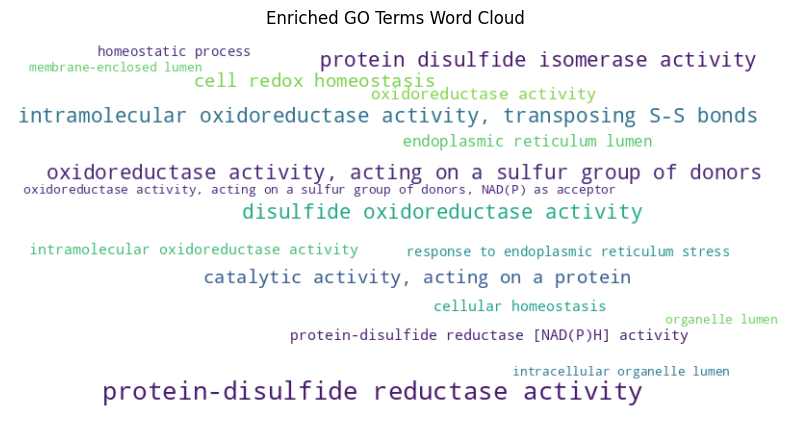

In [49]:
# Plot word cloud
plot_wordcloud(enrichment_df)

In [50]:
# Extract branches based on enrichment ratio
enriched_branches = get_enriched_branches(enrichment_df.head(30), go_obo_file, min_enrichment_ratio=0.7)
print_branches(enriched_branches, go_obo_file)

/content/drive/MyDrive/Biological-Data-Project/data/go.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms
/content/drive/MyDrive/Biological-Data-Project/data/go.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms
|- GO:0003674 (molecular_function)
   |- GO:0003824 (catalytic activity)
      |- GO:0140096 (catalytic activity, acting on a protein)
         |- GO:0016491 (oxidoreductase activity)
            |- GO:0016667 (oxidoreductase activity, acting on a sulfur group of donors)
               |- GO:0015036 (disulfide oxidoreductase activity)
                  |- GO:0016668 (oxidoreductase activity, acting on a sulfur group of donors, NAD(P) as acceptor)
                     |- GO:0015035 (protein-disulfide reductase activity)
                        |- GO:0047134 (protein-disulfide reductase [NAD(P)H] activity)
|- GO:0005575 (cellular_component)
   |- GO:0110165 (cellular anatomical structure)
      |- GO:0043226 (organelle)
         |- GO:0043227 (membrane-bounded organelle)
            |- GO:004322

# Motifs

In [51]:
# File paths
mobidb_file = f"{DATA_FOLDER}motifs/mobidb_lite_swissprot.csv"
elm_file = f"{DATA_FOLDER}motifs/elm_classes.tsv"
prosite_file = f"{DATA_FOLDER}motifs/prosite.dat.txt"

In [52]:
# Load disordered regions from MobiDB-Lite
disordered_regions_pd = pd.read_csv(mobidb_file, names =['Accession', 'Start_End'],
                                 converters={'Start_End': pd.eval} )
disordered_regions_pd

,Accession,Start_End
0,P9WEU3,"[[1493, 1529]]"
1,P9WEU4,"[[1, 84], [118, 141]]"
2,P0DTH5,"[[1, 38]]"
3,P0DO34,"[[1, 24]]"
4,P0DO30,"[[2520, 2583], [2597, 2621]]"
...,...,...
118676,Q8WYJ6,"[[352, 372]]"
118677,B2AFA8,"[[18, 51], [211, 249], [442, 525], [734, 761]]"
118678,Q93364,"[[1, 96]]"
118679,P34306,"[[1, 23]]"


In [53]:
disordered_regions = dict(zip(disordered_regions_pd["Accession"], disordered_regions_pd["Start_End"]))
disordered_regions

{'P9WEU3': array([[1493, 1529]], dtype=object),
 'P9WEU4': array([[1, 84],
        [118, 141]], dtype=object),
 'P0DTH5': array([[1, 38]], dtype=object),
 'P0DO34': array([[1, 24]], dtype=object),
 'P0DO30': array([[2520, 2583],
        [2597, 2621]], dtype=object),
 'P0DO27': array([[1, 26]], dtype=object),
 'P0DUK1': array([[1, 53]], dtype=object),
 'Q6GZX1': array([[38, 60]], dtype=object),
 'Q6GZX3': array([[261, 294]], dtype=object),
 'Q6GZX0': array([[1, 20]], dtype=object),
 'Q197F8': array([[339, 397],
        [434, 458]], dtype=object),
 'Q197F3': array([[392, 435]], dtype=object),
 'Q197E7': array([[13, 34]], dtype=object),
 'Q6GZW1': array([[95, 119]], dtype=object),
 'Q6GZW0': array([[277, 322]], dtype=object),
 'Q6GZV5': array([[27, 61]], dtype=object),
 'Q197E9': array([[73, 169]], dtype=object),
 'Q6GZV4': array([[42, 71]], dtype=object),
 'Q197D2': array([[285, 337]], dtype=object),
 'Q197D0': array([[98, 127]], dtype=object),
 'Q6GZV6': array([[1, 24],
        [61, 91]

In [54]:
# Load ELM classes (Regex Patterns)
elm_classes_pd = pd.read_csv(elm_file, delimiter="\t", comment="#")
elm_classes_pd

,Accession,ELMIdentifier,FunctionalSiteName,Description,Regex,Probability,#Instances,#Instances_in_PDB
0,ELME000321,CLV_C14_Caspase3-7,Caspase cleavage motif,Caspase-3 and Caspase-7 cleavage site.,[DSTE][^P][^DEWHFYC]D[GSAN],0.003094,41,0
1,ELME000172,CLV_MEL_PAP_1,Melanisation activation site,Prophenoloxidase-activating proteinase (PAP) c...,[ILV]..R[VF][GS].,0.000105,12,0
2,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,N-Arg dibasic convertase (NRD/Nardilysin) clea...,(.RK)|(RR[^KR]),0.007465,2,0
3,ELME000101,CLV_PCSK_FUR_1,PCSK cleavage site,Furin (PACE) cleavage site (R-X-[RK]-R-|-X).,R.[RK]R.,0.000509,13,0
4,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,Yeast kexin 2 cleavage site (K-R-|-X or R-R-|-X).,[KR]R.,0.007973,1,0
...,...,...,...,...,...,...,...,...
348,ELME000271,TRG_NLS_MonoExtN_4,NLS classical Nuclear Localization Signals,Monopartite variant of the classical basically...,"(([PKR].{0,1}[^DE])|([PKR]))((K[RK])|(RK))(([^...",0.001276,28,2
349,ELME000546,TRG_Oom_RxLR_1,Oomycete secretory protein processing motif pe...,Oomycete host targeting signal,((R)|(K.)).LR,0.000583,5,0
350,ELME000462,TRG_Pf-PMV_PEXEL_1,Apicomplexan export motif,"Plasmodium Export Element, PEXEL, is a traffic...",(R.[LI].[EDQ])|(R.L..[EDQ])|(K.L.E),0.002161,24,0
351,ELME000009,TRG_PTS1,PTS1,Generic PTS1 ELM for all eukaryotes,(.[SAPTC][KRH][LMFI]$)|([KRH][SAPTC][NTS][LMFI]$),0.000015,5,1


In [55]:
elm_patterns = dict(zip(elm_classes_pd["ELMIdentifier"], elm_classes_pd["Regex"]))
elm_patterns

{'CLV_C14_Caspase3-7': '[DSTE][^P][^DEWHFYC]D[GSAN]',
 'CLV_MEL_PAP_1': '[ILV]..R[VF][GS].',
 'CLV_NRD_NRD_1': '(.RK)|(RR[^KR])',
 'CLV_PCSK_FUR_1': 'R.[RK]R.',
 'CLV_PCSK_KEX2_1': '[KR]R.',
 'CLV_PCSK_PC1ET2_1': 'KR.',
 'CLV_PCSK_PC7_1': 'R...[KR]R.',
 'CLV_PCSK_SKI1_1': '[RK].[AILMFV][LTKF].',
 'CLV_Separin_Fungi': 'S[IVLMH]E[IVPFMLYAQR]GR.',
 'CLV_Separin_Metazoa': 'E[IMPVL][MLVP]R.',
 'CLV_TASPASE1': 'Q[MLVI]DG..[DE]',
 'DEG_APCC_DBOX_1': '.R..L..[LIVM].',
 'DEG_APCC_KENBOX_2': '.KEN.',
 'DEG_APCC_TPR_1': '.[ILM]R$',
 'DEG_Cend_DCAF12_1': '..EE$',
 'DEG_Cend_FEM1AC_1': '[RK].{1,2}R$',
 'DEG_Cend_FEM1B_2': '.L.R$',
 'DEG_Cend_KLHDC2_1': '...G[GA]$',
 'DEG_Cend_TRIM7_1': '[^P][^P][FL]Q$',
 'DEG_COP1_1': '[STDE]{1,3}.{0,2}[TSDE].{2,3}VP[STDE]G{0,1}[FLIMVYPA]',
 'DEG_CRBN_cyclicCter_1': '...[NQ]$',
 'DEG_CRL4_CDT2_1': '[NQ]{0,1}..[ILMV][ST][DEN][FY][FY].{2,3}[KR]{2,3}[^DE]',
 'DEG_CRL4_CDT2_2': '[NQ]{0,1}..[ILMV]T[DEN][HMFY][FMY].{2,3}[KR]{2,3}[^DE]',
 'DEG_Kelch_actinfilin_1': '[AP]P[

In [56]:
# Extract ProSite patterns (PA lines only)
prosite_patterns = []
with open(prosite_file, "r") as file:
    for record in Prosite.parse(file):
        if record.type == 'PATTERN':
            prosite_patterns.append((record.name,
                                     record.accession,
                                     record.description,
                                     record.pattern,
                                     record.nr_sp_seqs))
prosite_pd = pd.DataFrame(prosite_patterns, columns=['Name', 'Accession', 'Description', 'Pattern', 'Instances_sprot'])
prosite_pd

,Name,Accession,Description,Pattern,Instances_sprot
0,ASN_GLYCOSYLATION,PS00001,N-glycosylation site.,N-{P}-[ST]-{P}.,
1,CAMP_PHOSPHO_SITE,PS00004,cAMP- and cGMP-dependent protein kinase phosph...,[RK](2)-x-[ST].,
2,PKC_PHOSPHO_SITE,PS00005,Protein kinase C phosphorylation site.,[ST]-x-[RK].,
3,CK2_PHOSPHO_SITE,PS00006,Casein kinase II phosphorylation site.,[ST]-x(2)-[DE].,
4,TYR_PHOSPHO_SITE_1,PS00007,Tyrosine kinase phosphorylation site 1.,[RK]-x(2)-[DE]-x(3)-Y.,
...,...,...,...,...,...
1306,SCORPION_CALCINE,PS60028,Scorpion calcine family signature.,C-x(6)-C-x(5)-C-C-x(3)-C-x(9)-R-C.,
1307,SPIDER_CSTX,PS60029,Spider toxin CSTX family signature.,C-{C}(6)-C-{C}(6)-C-C-{C}(8)-C-{C}-C.,
1308,BACTERIOCIN_IIA,PS60030,Bacteriocin class IIa family signature.,Y-G-N-G-[VL]-x-C-x(4)-C.,
1309,GARP2,PS60031,Glutamic acid-rich protein 2 (GARP2) signature.,C-D-V-Q-T-R-[VAE]-[MVT]-[GA]-A-G-[GS]-L.,


In [57]:
# Convert ProSite Pattern to Regex
def prosite_to_re(pattern):
    """Convert a valid Prosite pattern into a regex string"""
    _prosite_trans = str.maketrans("abcdefghijklmnopqrstuvwxyzX}()<>",
                                  "ABCDEFGHIJKLMNOPQRSTUVW.YZ.]{}^$")
    flg = (pattern[:2] == "[<")
    s = pattern.replace("{", "[^")
    s = s.replace(".", "")
    s = s.replace("-", "")
    s = s.translate(_prosite_trans)
    # special case "[<" and ">]", if they exist
    if flg:
        i = s.index("]")
        s = "(?:^|[" + s[2:i] + "])" + s[i+1:]
    if s[-2:] == "$]":
        i = s.rindex("[")
        s = s[:i] + "(?:" + s[i:-2] + "]|$)"
    elif s[-3:] == "$]$":
        i = s.rindex("[")
        s = s[:i] + "(?:" + s[i:-3] + "]|$)$"
    return s

In [58]:
prosite_pd['Regex'] = prosite_pd["Pattern"].apply(prosite_to_re)
prosite_pd

,Name,Accession,Description,Pattern,Instances_sprot,Regex
0,ASN_GLYCOSYLATION,PS00001,N-glycosylation site.,N-{P}-[ST]-{P}.,,N[^P][ST][^P]
1,CAMP_PHOSPHO_SITE,PS00004,cAMP- and cGMP-dependent protein kinase phosph...,[RK](2)-x-[ST].,,[RK]{2}.[ST]
2,PKC_PHOSPHO_SITE,PS00005,Protein kinase C phosphorylation site.,[ST]-x-[RK].,,[ST].[RK]
3,CK2_PHOSPHO_SITE,PS00006,Casein kinase II phosphorylation site.,[ST]-x(2)-[DE].,,[ST].{2}[DE]
4,TYR_PHOSPHO_SITE_1,PS00007,Tyrosine kinase phosphorylation site 1.,[RK]-x(2)-[DE]-x(3)-Y.,,[RK].{2}[DE].{3}Y
...,...,...,...,...,...,...
1306,SCORPION_CALCINE,PS60028,Scorpion calcine family signature.,C-x(6)-C-x(5)-C-C-x(3)-C-x(9)-R-C.,,C.{6}C.{5}CC.{3}C.{9}RC
1307,SPIDER_CSTX,PS60029,Spider toxin CSTX family signature.,C-{C}(6)-C-{C}(6)-C-C-{C}(8)-C-{C}-C.,,C[^C]{6}C[^C]{6}CC[^C]{8}C[^C]C
1308,BACTERIOCIN_IIA,PS60030,Bacteriocin class IIa family signature.,Y-G-N-G-[VL]-x-C-x(4)-C.,,YGNG[VL].C.{4}C
1309,GARP2,PS60031,Glutamic acid-rich protein 2 (GARP2) signature.,C-D-V-Q-T-R-[VAE]-[MVT]-[GA]-A-G-[GS]-L.,,CDVQTR[VAE][MVT][GA]AG[GS]L


In [59]:
prosite_patterns = dict(zip(prosite_pd["Name"], prosite_pd["Regex"]))
prosite_patterns

{'ASN_GLYCOSYLATION': 'N[^P][ST][^P]',
 'CAMP_PHOSPHO_SITE': '[RK]{2}.[ST]',
 'PKC_PHOSPHO_SITE': '[ST].[RK]',
 'CK2_PHOSPHO_SITE': '[ST].{2}[DE]',
 'TYR_PHOSPHO_SITE_1': '[RK].{2}[DE].{3}Y',
 'MYRISTYL': 'G[^EDRKHPFYW].{2}[STAGCN][^P]',
 'AMIDATION': '.G[RK][RK]',
 'ASX_HYDROXYL': 'C.[DN].{4}[FY].C.C',
 'GLA_1': 'E.{2}[ERK]E.C.{6}[EDR].{10,11}[FYA][YW]',
 'PHOSPHOPANTETHEINE': '[DEQGSTALMKRH][LIVMFYSTAC][GNQ][LIVMFYAG][DNEKHS]S[LIVMST][^PCFY][STAGCPQLIVMF][LIVMATN][DENQGTAKRHLM][LIVMWSTA][LIVGSTACR][^LPIY][^VY][LIVMFA]',
 'ER_TARGET': '[KRHQSA][DENQ]EL$',
 'RGD': 'RGD',
 'ATP_GTP_A': '[AG].{4}GK[ST]',
 'EF_HAND_1': 'D[^W][DNS][^ILVFYW][DENSTG][DNQGHRK][^GP][LIVMC][DENQSTAGC].{2}[DE][LIVMFYW]',
 'ACTININ_1': '[EQ][^LNYH].[ATV][FY][^LDAM][^T]W[^PG]N',
 'ACTININ_2': '[LIVM].[SGNL][LIVMN][DAGHENRS][SAGPNVT].[DNEAG][LIVM].[DEAGQ].{4}[LIVM].[LM][SAG][LIVM][LIVMT][WS].{0,1}[LIVM]{2}',
 'KRINGLE_1': '[FY]C[RH][NS].{7,8}[WY]C',
 'EGF_1': 'C.C.{2}[^V].{2}G[^C].C',
 'FN2_1': 'C.{2}PF.[FYWIV].{7}

In [60]:
# Fetch protein sequences from UniProt
def fetch_protein_sequence(accession):
    url = f"https://www.uniprot.org/uniprot/{accession}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        return "".join(response.text.split("\n")[1:])  # Remove FASTA header
    return None

In [61]:
# Find Motifs Inside Disordered Regions
def find_motifs(sequence, motifs, disordered_regions):
    """Find motifs inside disordered protein regions."""
    matches = []
    for name, pattern in motifs.items():
        for match in re.finditer(pattern, sequence):
            start, end = match.start(), match.end()
            # Ensure match is inside disordered regions
            if any(s <= start and end <= e for s, e in disordered_regions):
                matches.append((name, start, end, sequence[start:end]))
    return matches

In [62]:
# Compute Z-Score and P-Value for Motif Conservation
def compute_conservation_stats(motif_counts):
    """Calculate Z-score & p-value for significantly conserved motifs."""
    counts = np.array(list(motif_counts.values()))
    mean, std = np.mean(counts), np.std(counts)

    significant_motifs = {}
    for motif, count in motif_counts.items():
        z_score = (count - mean) / std if std > 0 else 0
        p_value = 1 - norm.cdf(z_score)  # Right-tailed test
        if p_value < 0.05:  # Significance threshold
            significant_motifs[motif] = (count, z_score, p_value)

    return significant_motifs

In [63]:
prosite_motif_counts = {}
elm_motif_counts = {}

for protein_id in protein_ids:
    sequence = fetch_protein_sequence(protein_id)
    if sequence and protein_id in disordered_regions:
        disorder_regions = disordered_regions[protein_id]

        # Find motifs in ProSite & ELM
        prosite_matches = find_motifs(sequence, prosite_patterns, disorder_regions)
        elm_matches = find_motifs(sequence, elm_patterns, disorder_regions)

        # Count occurrences
        for match in prosite_matches:
            motif_name = match[0]
            prosite_motif_counts[motif_name] = prosite_motif_counts.get(motif_name, 0) + 1

        for match in elm_matches:
            motif_name = match[0]
            elm_motif_counts[motif_name] = elm_motif_counts.get(motif_name, 0) + 1


# Compute Significant Motifs
prosite_significant_motifs = compute_conservation_stats(prosite_motif_counts)
elm_significant_motifs = compute_conservation_stats(elm_motif_counts)

# Save Results
prosite_results = pd.DataFrame.from_dict(prosite_significant_motifs, orient="index", columns=["Count", "Z-Score", "P-Value"])
elm_results = pd.DataFrame.from_dict(elm_significant_motifs, orient="index", columns=["Count", "Z-Score", "P-Value"])

In [64]:
prosite_results

,Count,Z-Score,P-Value
CK2_PHOSPHO_SITE,204,2.006186,0.022418


In [65]:
prosite_pd[prosite_pd['Name'] == 'CK2_PHOSPHO_SITE']

,Name,Accession,Description,Pattern,Instances_sprot,Regex
3,CK2_PHOSPHO_SITE,PS00006,Casein kinase II phosphorylation site.,[ST]-x(2)-[DE].,,[ST].{2}[DE]


In [66]:
elm_results

,Count,Z-Score,P-Value
MOD_GSK3_1,191,5.114677,1.571393e-07
DOC_USP7_MATH_1,119,2.987711,1.405377e-03
LIG_WD40_WDR5_VDV_2,126,3.194499,7.003686e-04
MOD_CK2_1,107,2.633216,4.229022e-03
DOC_WW_Pin1_4,111,2.751381,2.967227e-03
LIG_SH3_3,79,1.806063,3.545426e-02
MOD_GlcNHglycan,142,3.667158,1.226305e-04
MOD_ProDKin_1,104,2.544593,5.470262e-03
MOD_CK1_1,156,4.080735,2.244676e-05


In [67]:
elm_classes_pd[elm_classes_pd['ELMIdentifier'].isin(['MOD_GSK3_1', 'DOC_USP7_MATH_1', 'LIG_WD40_WDR5_VDV_2', 'MOD_CK2_1',
                                                     'DOC_WW_Pin1_4', 'LIG_SH3_3', 'MOD_GlcNHglycan', 'MOD_ProDKin_1', 'MOD_CK1_1'])]

,Accession,ELMIdentifier,FunctionalSiteName,Description,Regex,Probability,#Instances,#Instances_in_PDB
81,ELME000239,DOC_USP7_MATH_1,USP7 binding motif,The USP7 MATH domain binding motif variant bas...,[PA][^P][^FYWIL]S[^P],0.012388,10,6
85,ELME000136,DOC_WW_Pin1_4,WW domain ligands,The Class IV WW domain interaction motif is re...,...([ST])P.,0.015433,96,1
240,ELME000155,LIG_SH3_3,SH3 domain ligands,This is the motif recognized by those SH3 doma...,...[PV]..P,0.013173,26,1
274,ELME000365,LIG_WD40_WDR5_VDV_2,"WDR5 WD40 repeat (blade 5,6)-binding ligand",Fungi-specific variant of the WDR5-binding mot...,"[EDSTY].{0,4}[VIPLA][TSDEKR][ILVA]",0.046779,2,0
292,ELME000063,MOD_CK1_1,Casein kinase 1 (CK1) Phosphorylation site,CK1 phosphorylation site,S..([ST])...,0.017041,27,0
293,ELME000064,MOD_CK2_1,Casein kinase 2 (CK2) Phosphorylation site,Casein kinase 2 (CK2) phosphorylation site,...([ST])..E,0.014568,34,0
297,ELME000085,MOD_GlcNHglycan,Glycosaminoglycan attachment site,Glycosaminoglycan attachment site,"[ED]{0,3}.(S)[GA].",0.017919,6,0
298,ELME000053,MOD_GSK3_1,GSK3 phosphorylation site,GSK3 phosphorylation recognition site,...([ST])...[ST],0.026787,22,0
317,ELME000159,MOD_ProDKin_1,MAPK Phosphorylation Site,Proline-Directed Kinase (e.g. MAPK) phosphoryl...,...([ST])P..,0.015433,38,0
